## 직접 만들어보는 OCR

OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하자.

Recognition은 직접 만들어 학습해보도록 하겠다.

### keras-ocr

- segmentation 기반의 CRAFT 를 활용한 keras-ocr 을 이용하여 Text Detection 수행
- keras-ocr 도 recognition 을 지원함 (RCNN 기반)
- 공식 github : https://github.com/faustomorales/keras-ocr

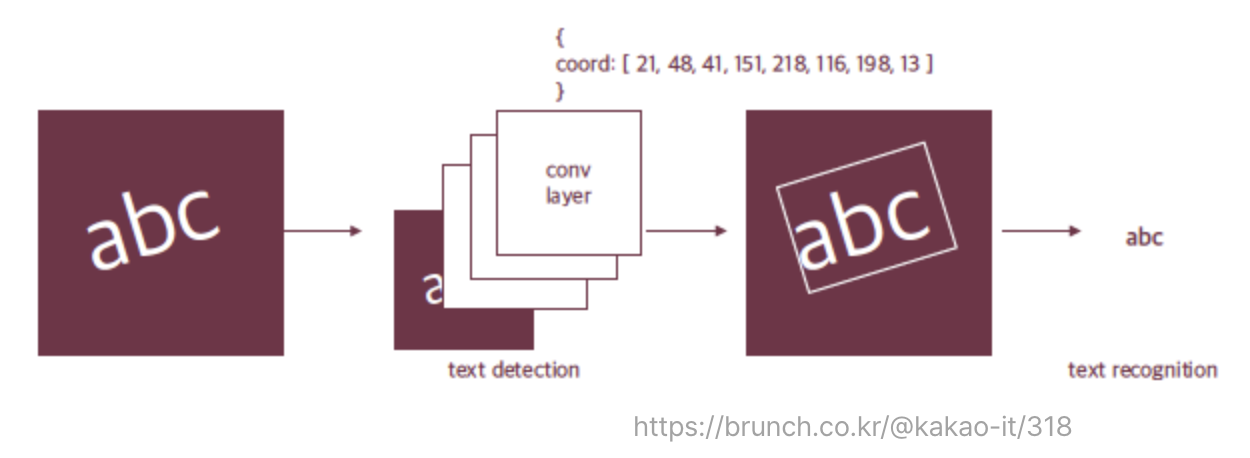

In [5]:
from IPython.display import Image
Image(filename='capture/overall_structure_of_ocr.png', width=600) 

### Dataset for OCR

- OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움이 있다. 
- 따라서 OCR 데이터를 대량으로 만들려면 큰 비용이 든다. 
- 데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 방법이 있다.
- 직접 문자 데이터를 생성하게 되면, 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 문자 이미지를 대량으로 만들어낼 수 있다는 장점이 있다.

Recognition model 의 정량적인 평가를 위해서 MJSynth 와 SynthText 라는 데이터셋을 활용한다.

MJSynth
- http://www.robots.ox.ac.uk/~vgg/data/text/ 참고

SynthText
- http://www.robots.ox.ac.uk/~vgg/data/scenetext/ 참고

아래의 링크는 Naver Clova의 논문 저자들이 Dropbox를 통해 제공하는 데이터셋  
아래 링크의 training 폴더에서 data_lmdb_release.zip 내 있는 MJ 데이터만 활용할 예정  
https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0

용량이 크다. 20기가 정도. 느긋하게 다운로드 받자.

### Recognition model 만들기

#### CRNN 구조를 활용

Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보자.  
https://arxiv.org/pdf/1507.05717.pdf 참고

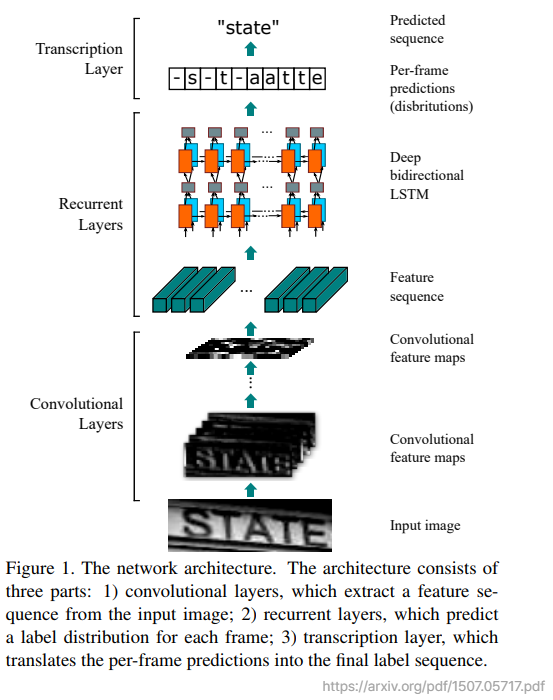

In [1]:
from IPython.display import Image
Image(filename='capture/rcnn.png') 

아래부터 위로 올라가는 순서
- Input image 를 Convolution Layer 를 통해서 Feature 를 추출
- 추출된 Feature 를 Recurrent Layer 에 입력
- Recurrent Layer 는 추출된 Feature 의 전체적인 Context 를 파악하고 다양한 output 의 크기에 대응이 가능
- 끝으로 Transcription Layer (Fully Connected Layer) 는 step 마다 어떤 character 의 확률이 높은지 예측

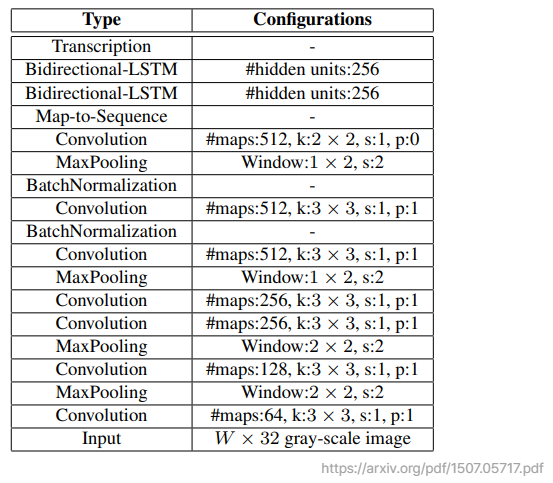

In [2]:
from IPython.display import Image
Image(filename='capture/rcnn_model_architecture.png') 

몇 개의 클래스가 필요한가?

In [8]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


총 36가지가 필요. 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개

lmdb를 이용할 예정
- LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자

여기서 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있음

In [6]:
! pip install lmdb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


필요한 라이브러리들을 import

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
BASE_DATA_DIR = '/home/jovyan/dataDrive/data_lmdb_release/training/MJ/'

TRAIN_DATA_PATH = BASE_DATA_DIR+'MJ_train'
VALID_DATA_PATH = BASE_DATA_DIR+'MJ_valid'
TEST_DATA_PATH = BASE_DATA_DIR+'MJ_test'

print(TRAIN_DATA_PATH)

/home/jovyan/dataDrive/data_lmdb_release/training/MJ/MJ_train


#### 이미지 확인

훈련데이터셋의 4개만 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


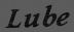

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


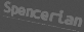

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


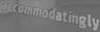

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


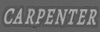

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현
- label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현
- 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있음.

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

- img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영
- model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 \_get_img_label() 를 통해 가져온 데이터셋을 리턴하게 됨
- get_img_label() 를 보면
  - 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있음

#### Encode

현재 Label 은 우리가 읽을 수 있는 평문 Text 임  
이를 학습에 사용할 수 있도록, 각 Character 를 class 로 생각하고 step 에 따른 class index 로 변환해서 encode 해줘야 함

LabelConverter

만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2  
공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정  
decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꿔줌

In [6]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

잘 되는지 확인

In [9]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있음

#### Build CRNN model

Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두자.

In [10]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

CTC Loss 를 활용해야 하는 모델은 다음 그림과 같은 상황을 다루기 위한 것임

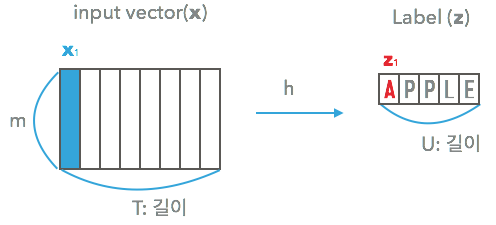

In [7]:
from IPython.display import Image
Image(filename='capture/ctc.png') 

모델 출력이 AAAPPPPLLLLEE 일 때, 이게 APLE 가 아니라 APPLE 이어야 하기 때문에  
모델이 AAAPP-PPLLLEE 로 출력하도록 공백문자 처리로직을 포함했던 것이다.

K.ctc_batch_cost()를 활용하여
- image_input을 입력으로, 
- 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수를 만들자

In [11]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 학습

MJDatasetSequence 로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습

In [12]:
# 데이터셋과 모델을 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

2022-09-08 08:27:43.238245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 08:27:44.063358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:0a:00.0, compute capability: 7.0
/opt/conda/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adadelta.py:79: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용
checkpoint_dir = './checkpoint/'
os.makedirs(checkpoint_dir)
checkpoint_path = checkpoint_dir + 'ocr_model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 6.7417
Epoch 1: val_loss improved from inf to 6.80693, saving model to ./checkpoint/ocr_model_checkpoint.hdf5
565/565 [==============================] - 41s 73ms/step - loss: 6.7417 - val_loss: 6.8069
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 4.9200
Epoch 2: val_loss improved from 6.80693 to 5.16648, saving model to ./checkpoint/ocr_model_checkpoint.hdf5
565/565 [==============================] - 40s 71ms/step - loss: 4.9200 - val_loss: 5.1665
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 3.9097
Epoch 3: val_loss improved from 5.16648 to 4.80754, saving model to ./checkpoint/ocr_model_checkpoint.hdf5
565/565 [==============================] - 41s 72ms/step - loss: 3.9097 - val_loss: 4.8075
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 3.1971
Epoch 4: val_loss improved from 4.80754 to 4.37240, saving model to ./checkpoint/ocr_model_checkpoint.

### 학습 모델 확인

테스트셋을 통해 확인

In [16]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
#checkpoint_path = 'if another file existed then'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

성능 확인

1/1 [==============================] - 2s 2s/step
Result: 	 SLINKING9999999999999999


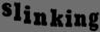

1/1 [==============================] - 0s 41ms/step
Result: 	 ALEPPO99999999999999999


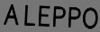

1/1 [==============================] - 0s 35ms/step
Result: 	 IFWENDA99999999999999999


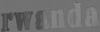

1/1 [==============================] - 0s 38ms/step
Result: 	 NATHANS99999999999999999


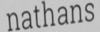

1/1 [==============================] - 0s 102ms/step
Result: 	 HALO99999999999999999999


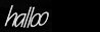

1/1 [==============================] - 0s 32ms/step
Result: 	 HURLS9999999999999999999


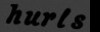

1/1 [==============================] - 0s 34ms/step
Result: 	 DOWNSIZE9999999999999999


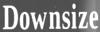

1/1 [==============================] - 0s 30ms/step
Result: 	 ROBOTIC99999999999999999


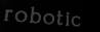

1/1 [==============================] - 0s 32ms/step
Result: 	 SLOPPY99999999999999999


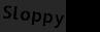

1/1 [==============================] - 0s 37ms/step
Result: 	 HERMITE99999999999999999


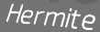

In [17]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)